In [7]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True
import pandas as pd
import numpy as np
import random
import os
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
import time
import networkx as nx
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
plt.rcParams['axes.unicode_minus']=False

path = 'result/spring_system'
if not os.path.exists(path):
    os.makedirs(path)
    

class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))
        

dataset shape: (2, 20000)
rho 2.9002688983782248


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (2, 101)
6.87699894637627e-05


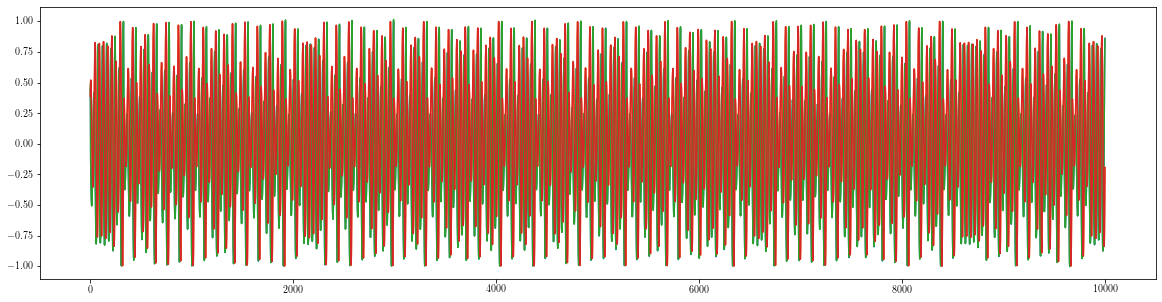

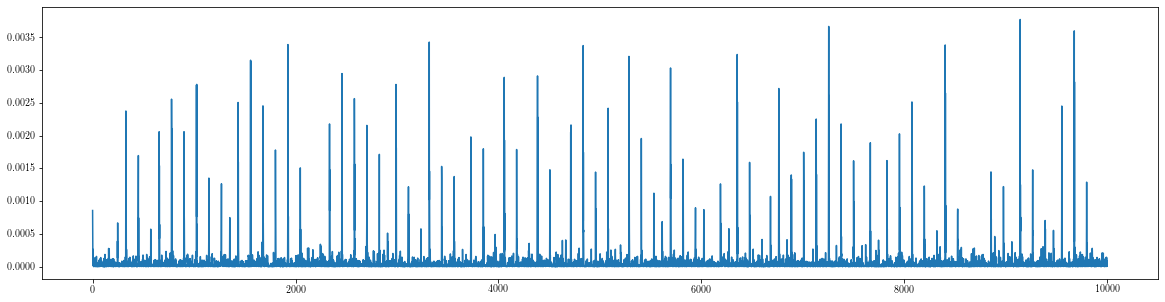

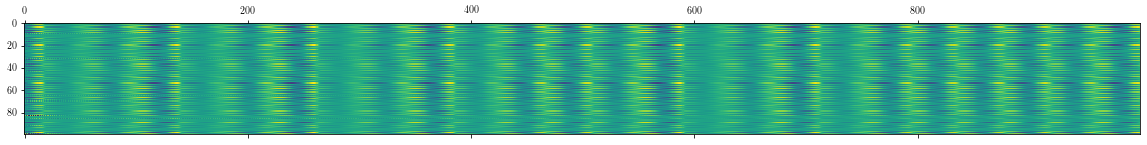

In [294]:
system_name = 'Rossler'
# system_name = 'Rabinovich Fabrikant'
# system_name = 'Lorenz'
# system_name ='Four-Scroll'


U0 = np.loadtxt('dataset/'+system_name+'.csv', delimiter=',').T[:2]
U = U0 + np.random.randn(*U0.shape)*1e-3
U = np.atleast_2d(U)
num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 1000
test_start = num_prepare + num_train + num_val
num_test = 5000
print('dataset shape:', U.shape)


inSize = U.shape[0]
outSize = inSize  
resSize = 100
dt = 1           # leaking rate
K = 1+np.diag(np.random.rand(resSize))         # spectial redius
reg = 1e-6      # regularization coefficient 
input_scaling = 1
# W = np.diag(np.random.rand(resSize))
# W = np.random.rand(resSize, resSize)
g = nx.erdos_renyi_graph(resSize, 0.0001, 42, True)
W = nx.adjacency_matrix(g).todense()

Win = np.random.rand(resSize,inSize)
Mask = np.zeros((resSize,inSize))
indice = np.array([i for i in range(resSize)])
for c in range(inSize):
    Mask[indice%inSize==c,c] = 1.
Win *= Mask

A = np.array([[1,dt],[dt*w, 1-dt*k]])
largest_eigvals, _ = largest_eigsh(A@A.T, 1, which='LM')
rhoA = np.sqrt(largest_eigvals[0])
print('rho',rhoA)
X1 = np.zeros((resSize,U.shape[1]))
X2 = np.zeros((resSize,U.shape[1]))
x1 = np.zeros([resSize,1])
x2 = np.zeros([resSize,1])

for t in tqdm(range(U.shape[1])):
    u = U[:,t:t+1]
    x2 = (1-dt*K) @ x2 + dt * (-W @ x2 + Win @ u)
#     x1 = np.tanh(x1 + dt*x2)
#     X1[:,t:t+1] = x1
    X2[:,t:t+1] = x2

# offline train
# X = np.vstack([X1,X2])
X = X2
X_train = X[:,train_start : train_start + num_train][:1000]
Y_train = U[:,train_start + 1 : train_start + num_train + 1]
H = np.vstack((np.ones((1,X_train.shape[1])),X_train))


Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
print('pre_output shape:', H.shape)
print('W_out shape:', Wout.shape)

plt.figure(figsize=(20,5))
plt.plot(Y_train.T)
plt.plot((Wout @ H).T)

plt.figure(figsize=(20,5))
sse = np.sum(np.square(Y_train - Wout @ H), axis=0)
plt.plot(sse)
print(np.average(sse))

# plt.figure(figsize=(20,5))
# _ = plt.plot(X2[:].T)
f,ax = plt.subplots(figsize=(20,5))
ax.matshow(X[:,:1000])

In [295]:
horizon = 2000
num_test = 1
pred = []
print(U.shape)
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        x1 = X[:resSize,test_start : test_start + num_test]
        x2 = X[resSize:,test_start : test_start + num_test]
    else:
        U_test = Y_pred
        x2 = np.tanh((1-dt*K) @ x2 + dt * (-W @ x1 + Win @ U_test))
        x1 = np.tanh(x1 + dt*x2)

    H = np.vstack((np.ones((1,num_test)),x1,x2))
    Y_pred = Wout @ H
    pred.append(Y_pred[0])

plt.figure(figsize=(20,10))
pred = np.array(pred).T
plt.plot(pred.T)
plt.plot(U[0,test_start+1 : test_start + horizon+1])

(2, 20000)


  0%|          | 0/2000 [00:00<?, ?it/s]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 0 is different from 100)

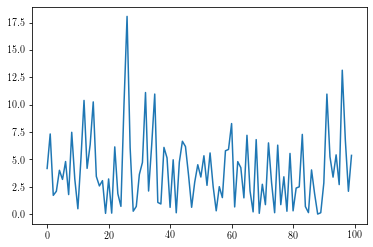

In [178]:
_ = plt.plot(abs(Wout[:,1+resSize:].T) + abs(Wout[:,1:1+resSize].T) )

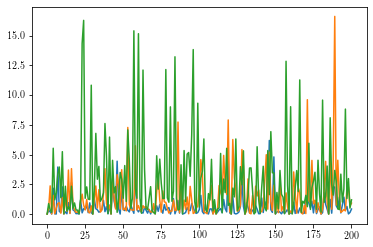

In [194]:
_ = plt.plot(abs(Wout[0].T))
_ = plt.plot(abs(Wout[1].T))
_ = plt.plot(abs(Wout[2].T))

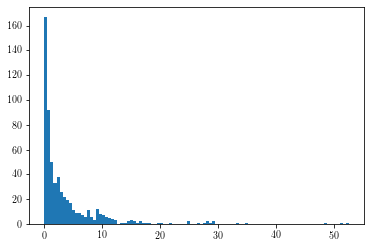

In [207]:
_ = plt.hist(abs(Wout.flatten()),bins=100)

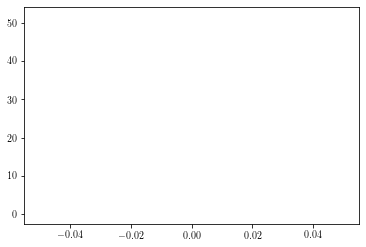

In [184]:
_ = plt.plot(H[np.sum(abs(Wout), axis=0) < np.quantile(abs(Wout), 0.1)].T)

In [183]:
np.quantile(Wout, 0.1)

-2.861303807039654

In [187]:
indice = np.array([i for i in range(resSize)])
indice%inSize == 0

array([ True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True])